## Practice Pulling Data from Sloan Digital Sky Survey (Specific Position Regions) ##

In [5]:
from astroquery.sdss import SDSS
from astropy import coordinates as coords

# Define the target position (RA, Dec) in degrees
target_position = coords.SkyCoord(ra=150, dec=2.0, unit='deg', frame='icrs')

# Query SDSS for photometric data
result = SDSS.query_region(target_position, radius='2.5 arcmin', photoobj_fields=['ra', 'dec', 'u', 'g', 'r', 'i', 'z'])

# Display the results
print(result)

       objID               ra              dec        ...    i        z    
------------------- ---------------- ---------------- ... -------- --------
1237651736280695060 150.023624228974 1.98308407457287 ... 20.23153 20.16952
1237653664721993906 150.023624473467 1.98307176930408 ... 20.06032 20.28649
1237651736280695589 150.027814149003 1.97759375068481 ... 21.30561 20.10799
1237651736280761147 150.027815971412 1.97758393121166 ...  -9999.0  -9999.0
1237653664721994648 150.027860559061 1.97762120675163 ... 21.60671 21.68682
1237651736280695469 150.003843593927 1.96947674466095 ...  21.1775 20.48815
1237653664721994548 150.003923534572 1.96945891345637 ... 20.66825 20.00115
1237651736280695475 150.016255389114 1.98372022762677 ...  19.8926 19.08648
1237653664721994553 150.016261752259  1.9837120467736 ... 19.99393 19.37196
1237651736280694976 150.012329161957 1.96169474387217 ... 16.75584 16.27265
                ...              ...              ... ...      ...      ...
123765173628

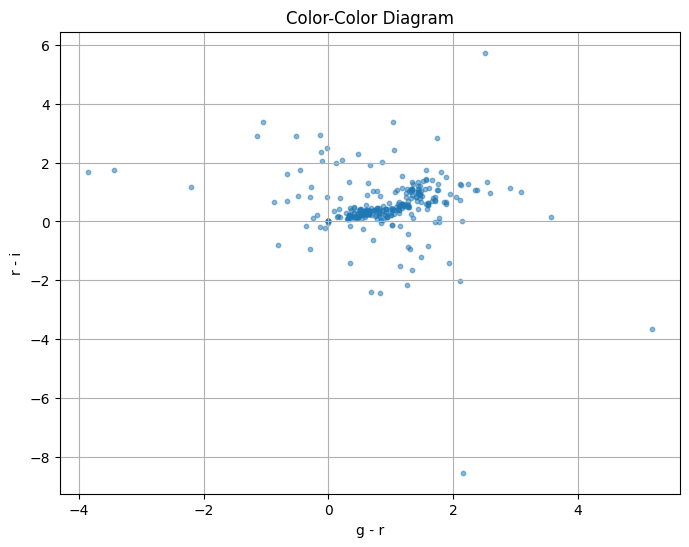

In [6]:
import matplotlib.pyplot as plt

# Calculate color indices
g_r = result['g'] - result['r']
r_i = result['r'] - result['i']

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(g_r, r_i, alpha=0.5, s=10)
plt.xlabel('g - r')
plt.ylabel('r - i')
plt.title('Color-Color Diagram')
plt.grid()
plt.show()

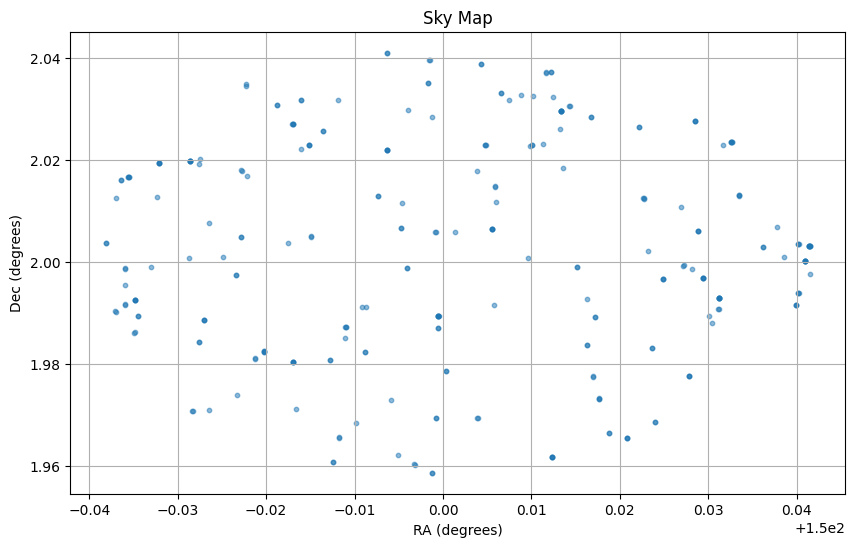

In [7]:
plt.figure(figsize=(10, 6))
plt.scatter(result['ra'], result['dec'], alpha=0.5, s=10)
plt.xlabel('RA (degrees)')
plt.ylabel('Dec (degrees)')
plt.title('Sky Map')
plt.grid()
plt.show()

In [8]:
# Query SDSS for spectroscopic data
spectro_result = SDSS.query_region(target_position, radius='2.5 arcmin', spectro=True)

# Display the spectroscopic results
print(spectro_result)

# Download spectra for the spectroscopic objects
spectra = SDSS.get_spectra(matches=spectro_result)
print(spectra)
# Save spectra to disk
for i, sp in enumerate(spectra):
    if sp[0].data is not None:
        filename = f'sdss_spectrum_{i}.fits'
        with open(filename, 'wb') as f:
            f.write(sp[0].data)
        print(f'Spectrum saved to {filename}')
    else:
        print(f'Spectrum {i} has no data and was not saved.')


       ra              dec        ...     specobjid      run2d
---------------- ---------------- ... ------------------ -----
150.023624228974 1.98308407457287 ... 563103093869275136    26
149.999475681066 1.98696565183524 ... 564151757127575552    26
149.977128943782 2.00485833766016 ... 564161652732225536    26
149.977128943782 2.00485833766016 ... 563090724363462656    26
150.013348111481 2.02956392334411 ... 563091274119276544    26
[[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x122af6d80>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x124243290>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x12424eb10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x124262660>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x1242718b0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x124273590>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x1242867b0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x124299940>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x124

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Load your dataset
# Example format: columns - redshift (z), distance modulus (mu), and mu error (mu_err)
# Replace 'sdss_supernovae_data.csv' with your actual file
data = np.loadtxt('sdss_supernovae_data.csv', delimiter=',', skiprows=1)
redshifts = data[:, 0]  # Redshift (z)
distance_modulus = data[:, 1]  # Distance modulus (mu)
mu_error = data[:, 2]  # Error in distance modulus (mu_err)

# Convert redshift to luminosity distance (parsecs) for plotting theoretical Hubble line
def luminosity_distance(z, H0=70, Omega_m=0.3, Omega_L=0.7):
    """
    Calculate the luminosity distance using a simple flat universe model.
    Parameters:
        z : array-like
            Redshift
        H0 : float
            Hubble constant in km/s/Mpc (default: 70)
        Omega_m : float
            Matter density parameter (default: 0.3)
        Omega_L : float
            Dark energy density parameter (default: 0.7)
    Returns:
        d_L : array-like
            Luminosity distance in Mpc
    """
    c = 299792.458  # Speed of light in km/s
    # Simplified luminosity distance formula (works for low to moderate z)
    d_L = (c / H0) * z * (1 + 0.5 * (1 - Omega_m + Omega_L) * z)  # Approximation
    return d_L * 1e6  # Convert Mpc to parsecs

# Generate a theoretical Hubble curve
z_theoretical = np.linspace(0.01, 1.0, 100)  # Redshift range
d_L_theoretical = luminosity_distance(z_theoretical)
mu_theoretical = 5 * np.log10(d_L_theoretical) - 5

# Plot the Hubble diagram
plt.figure(figsize=(10, 6))
plt.errorbar(redshifts, distance_modulus, yerr=mu_error, fmt='o', label='SDSS Supernovae', capsize=3)
plt.plot(z_theoretical, mu_theoretical, label='Theoretical Curve ($\Lambda$CDM)', color='red')
plt.xscale('log')  # Logarithmic scale for redshift
plt.xlabel('Redshift ($z$)')
plt.ylabel('Distance Modulus ($\mu$)')
plt.title('Hubble Diagram: SDSS Supernovae')
plt.legend()
plt.grid()
plt.show()

<>:42: SyntaxWarning: invalid escape sequence '\L'
<>:45: SyntaxWarning: invalid escape sequence '\m'
<>:42: SyntaxWarning: invalid escape sequence '\L'
<>:45: SyntaxWarning: invalid escape sequence '\m'
/var/folders/71/hv72gkrs7g59ty6664549kjr0000gr/T/ipykernel_12760/4075518381.py:42: SyntaxWarning: invalid escape sequence '\L'
  plt.plot(z_theoretical, mu_theoretical, label='Theoretical Curve ($\Lambda$CDM)', color='red')
/var/folders/71/hv72gkrs7g59ty6664549kjr0000gr/T/ipykernel_12760/4075518381.py:45: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Distance Modulus ($\mu$)')


FileNotFoundError: sdss_supernovae_data.csv not found.

## Hubble Diagram Practice ##

In [11]:
from astroquery.sdss import SDSS
from astropy import coordinates as coords
import pandas as pd


# Define a region of interest or use catalog queries
pos = coords.SkyCoord('10h00m00s +02d00m00s', frame='icrs')  # Example position
result = SDSS.query_region(pos,radius='2.5 arcmin', spectro=True)  # Query SDSS for spectroscopic data
print(result)

# Check if result is not None
if result is not None:
    # Convert the result to a pandas DataFrame
    df = result.to_pandas()
    
    # Save the DataFrame to a CSV file
    df.to_csv('supernova_lightcurve.csv', index=False)
    print("Results saved to 'supernova_lightcurve.csv'")
else:
    print("No results found.")


       ra              dec        ...     specobjid      run2d
---------------- ---------------- ... ------------------ -----
150.023624228974 1.98308407457287 ... 563103093869275136    26
149.999475681066 1.98696565183524 ... 564151757127575552    26
149.977128943782 2.00485833766016 ... 564161652732225536    26
149.977128943782 2.00485833766016 ... 563090724363462656    26
150.013348111481 2.02956392334411 ... 563091274119276544    26
Results saved to 'supernova_lightcurve.csv'


In [13]:
import sncosmo
import numpy as np

# Load your data (replace with actual file or data array)
# Example light curve data with columns: time, flux, flux_err, band
data = np.genfromtxt('supernova_lightcurve.csv', delimiter=',', names=True)

# Define the SALT2 model
model = sncosmo.Model(source='salt2')

# Fit the light curve
result, fitted_model = sncosmo.fit_lc(
    data,
    model,
    ['z', 't0', 'x0', 'x1', 'c'],  # Parameters to fit
    bounds={'z': (0.01, 1.0)}      # Redshift range
)

# Print the fitted parameters
print("Fitted parameters:")
for param in ['z', 't0', 'x0', 'x1', 'c']:
    print(f"{param}: {result.parameters[model.param_names.index(param)]}")

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

## Another Attempt to Get DSLS Datat ##


In [14]:
from astroquery.sdss import SDSS
from astropy import coordinates as coords
import pandas as pd
import numpy as np

# Define a region of interest
pos = coords.SkyCoord('10h00m00s +02d00m00s', frame='icrs')  # Example position

# Query SDSS for photometric data
photometric_data = SDSS.query_region(pos, radius='2.5 arcmin', photoobj_fields=['ra', 'dec', 'run', 'rerun', 'camcol', 'field', 'u', 'g', 'r', 'i', 'z'])

# Check if photometric_data is not None
if photometric_data is not None:
    # Convert the result to a pandas DataFrame
    df = photometric_data.to_pandas()

    # Preprocess the data to create the required columns
    # For demonstration, we'll use the 'g' band for flux and generate dummy time and flux error data
    df['time'] = np.linspace(0, 100, len(df))  # Example time data
    df['flux'] = df['g']  # Example flux data using 'g' band magnitude
    df['flux_err'] = np.random.normal(0.1, 0.01, len(df))  # Example flux error data
    df['band'] = 'sdssg'  # Example band data

    # Select only the required columns
    light_curve_data = df[['time', 'flux', 'flux_err', 'band']]

    # Save the DataFrame to a CSV file
    light_curve_data.to_csv('supernova_lightcurve.csv', index=False)
    print("Results saved to 'supernova_lightcurve.csv'")
else:
    print("No photometric data found.")

Results saved to 'supernova_lightcurve.csv'


In [15]:
import sncosmo
import numpy as np

# Load your data
data = np.genfromtxt('supernova_lightcurve.csv', delimiter=',', names=True)

# Define the SALT2 model
model = sncosmo.Model(source='salt2')

# Print the model parameter names to verify
print("Model parameter names:", model.param_names)

# Fit the light curve
result, fitted_model = sncosmo.fit_lc(
    data,
    model,
    ['z', 't0', 'x0', 'x1', 'c'],  # Parameters to fit
    bounds={'z': (0.01, 1.0)}      # Redshift range
)

# Print the fitted parameters
print("Fitted parameters:")
for param in ['z', 't0', 'x0', 'x1', 'c']:
    print(f"{param}: {result.parameters[model.param_names.index(param)]}")

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

/var/folders/71/hv72gkrs7g59ty6664549kjr0000gr/T/ipykernel_12760/3280270815.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv('jla_lcparams.txt', delim_whitespace=True)


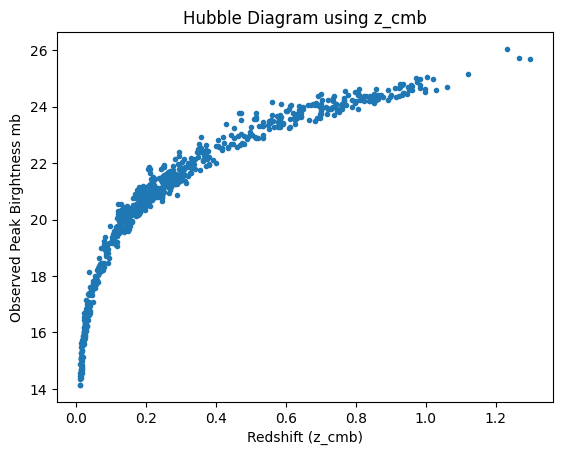

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load data
data = pd.read_csv('jla_lcparams.txt', delim_whitespace=True)

# Extract zcmb
z = data['zcmb']
mb = data['mb']

# Plot
plt.plot(z, mb, 'o', markersize=3)
plt.xlabel('Redshift (z_cmb)')
plt.ylabel('Observed Peak Birghtness mb')
plt.title('Hubble Diagram using z_cmb')
plt.show()

/var/folders/71/hv72gkrs7g59ty6664549kjr0000gr/T/ipykernel_12760/1744947868.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True)


    #name      zcmb    zhel   dz         mb       dmb        x1       dx1  \
0  03D1au  0.503084  0.5043  0.0  23.001698  0.088031  1.273191  0.150058   
1  03D1aw  0.580724  0.5820  0.0  23.573937  0.090132  0.974346  0.273823   
2  03D1ax  0.494795  0.4960  0.0  22.960139  0.088110 -0.728837  0.102069   
3  03D1bp  0.345928  0.3470  0.0  22.398137  0.087263 -1.155110  0.112834   
4  03D1co  0.677662  0.6790  0.0  24.078115  0.098356  0.618820  0.404295   

      color    dcolor  3rdvar  d3rdvar   cov_m_s   cov_m_c   cov_s_c  set  
0 -0.012353  0.030011   9.517   0.1105  0.000790  0.000440 -0.000030    1  
1 -0.025076  0.036691   9.169   0.0880  0.002823  0.000415  0.001574    1  
2 -0.099683  0.030305  11.580   0.1125  0.000542  0.000475 -0.000024    1  
3 -0.040581  0.026679  10.821   0.1235  0.001114  0.000616  0.000295    1  
4 -0.039380  0.067403   8.647   0.2840  0.011857  0.000780  0.005898    1  


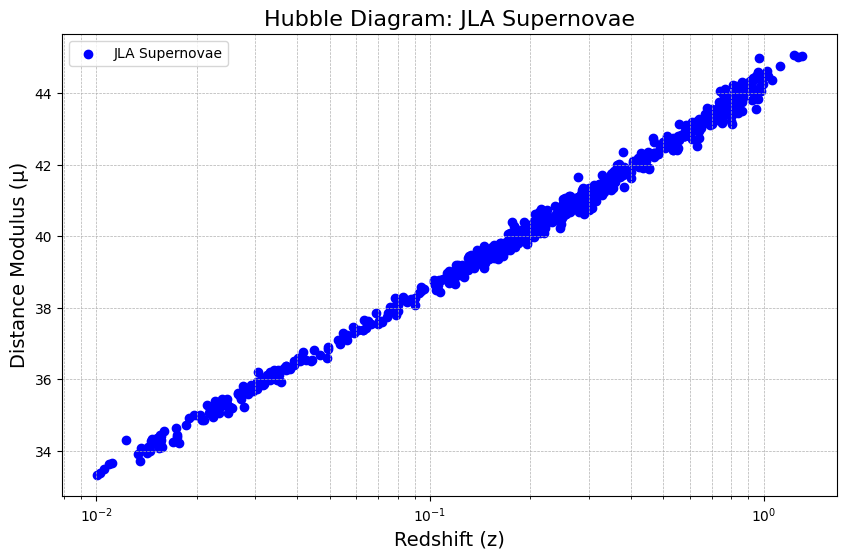

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load the data file
file_path = "jla_lcparams.txt"  # Replace with your file path
data = pd.read_csv(file_path, delim_whitespace=True)

# Display the first few rows to inspect the data
print(data.head())

# Extract relevant columns
zcmb = data['zcmb']  # Redshift (CMB frame)
mb = data['mb']      # Peak magnitude
x1 = data['x1']      # Stretch
color = data['color']  # Color parameter

# SALT2 coefficients
alpha = 0.14
beta = 3.1
MB = -19.3

# Calculate distance modulus
mu = mb - MB + alpha * x1 - beta * color

# Plot the Hubble diagram
plt.figure(figsize=(10, 6))
plt.scatter(zcmb, mu, color='blue', label='JLA Supernovae')
plt.xscale('log')  # Use a logarithmic scale for redshift
plt.xlabel('Redshift (z)', fontsize=14)
plt.ylabel('Distance Modulus (μ)', fontsize=14)
plt.title('Hubble Diagram: JLA Supernovae', fontsize=16)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.show()